In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
hs_full_geo = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\hs_full_geo.geojson')
hs_2028_geo = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\GIS_files\\pu_with_proj_SPLIT.geojson').to_crs(epsg=3857)
hs_2028_geo.head(2)

,pu_2324_84,student_gen,basez,final_proj,geometry
0,1,0,0.0,0.0,"POLYGON ((-8.77e+06 4.33e+06, -8.77e+06 4.33e+..."
1,2,0,4.0,4.0,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+..."


In [6]:
dps_base = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\dps_base_2324.geojson')
dps_base = dps_base.to_crs(epsg = 3857)
base_hs = {'Jordan High School','Riverside High School','Northern High School','Hillside High School','Southern High School'}
dps_base_hs = dps_base[dps_base['name'].isin(base_hs)]
dps_base_hs = dps_base_hs[['name','geometry']]
dps_base_hs.loc[6,'name']='New High School'
dps_base_hs = dps_base_hs.reset_index()

In [7]:
dps_pu = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\GIS_Files\\pu_2324_SPLIT.geojson').rename(columns={'pu_2324_848':'pu_2324_84'})
dps_pu = dps_pu.to_crs(epsg = 3857).sort_values(by='pu_2324_84')
dps_pu.head()

,OBJECTID,pu_2324_84,X,Y,M_min,PS_ID,PUID2122_2,ps_id_833,psid_982,TIMS_PU,Region,Shape_Length,Shape_Area,geometry
0,1,1,2.049028e+06,893128.606346,0.0,589,589,1,1,PU589,North,26532.120021,3.556198e+07,"POLYGON ((-8.77e+06 4.33e+06, -8.77e+06 4.33e+..."
1,2,2,2.039923e+06,835434.121317,0.0,401,401,2,2,PU401,North,19333.085511,2.080136e+07,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+..."
2,3,3,2.058005e+06,797649.028742,0.0,782,782.0,3,3,PU782.0,East,18314.823119,1.329077e+07,"POLYGON ((-8.77e+06 4.29e+06, -8.77e+06 4.29e+..."
3,4,4,2.003222e+06,772895.737307,0.0,201,201.0,4,4,PU201.0,Southwest,29282.100083,4.684140e+07,"POLYGON ((-8.79e+06 4.29e+06, -8.79e+06 4.29e+..."
4,5,5,2.067334e+06,828244.230730,0.0,646,646,6,6,PU646,East,60685.151474,1.497046e+08,"POLYGON ((-8.77e+06 4.3e+06, -8.77e+06 4.3e+06..."


In [12]:
def score_candidate(candidate):
    school_names = ['Southern High School','Hillside High School','Northern High School','Riverside High School','Jordan High School','New High School']
    capacities = [1800,1800,2000,1800,1600,1600]

    counts = pd.DataFrame({'school':school_names,
                           'capacity':capacities,
                           'count':[0,0,0,0,0,0],
                           'coefficient':[1,1,1,1,1,1]
                            })                               #initialize counts dataframe

    
    candidate_geom = candidate['geometry']
    dps_base_hs.loc[5,'geometry']=candidate_geom.centroid
    

    for i in range(30):                                      #iterative boundary assignment (running 10x)
        assignments = []
        for pu in hs_full_geo.itertuples(index=False):                   
            centroid = pu.geometry.centroid
            pu_scores = []
            for j in range(6):                               #5 existing schools and 1 new
                dist = centroid.distance(dps_base_hs.loc[j,'geometry'])
                score = dist * counts.loc[j,'coefficient']
                pu_scores.append(score)
            assign = school_names[pu_scores.index(min(pu_scores))]
            assignments.append(assign)                        #collect hs assignments based on min distance score
        hs_full_geo['assign'] = assignments

        for i,school in enumerate(school_names):
            assigned_students = hs_full_geo.loc[hs_full_geo['assign'] == school, 'count'].sum()
            counts.loc[i, 'count'] = assigned_students                    #sum up counts for all high schools and update coefficients
        counts['coefficient'] *= (counts['count']/counts['capacity'])**0.1

    objective=hs_full_geo.merge(dps_base_hs,left_on='assign',right_on='name',how='left')
    objective['distance']=objective['geometry_x'].distance(objective['geometry_y'])
    objective_score = (objective['count']*objective['distance']).sum()/(10**7)

    return objective_score,counts

candidate = dps_pu.loc[516]
score_candidate(candidate)

(4.67254016266559,
                   school  capacity  count  coefficient
 0   Southern High School      1800   1894     1.188118
 1   Hillside High School      1800   1980     1.794172
 2   Northern High School      2000   2109     1.127110
 3  Riverside High School      1800   1904     0.967377
 4     Jordan High School      1600   1723     1.492597
 5        New High School      1600   1697     0.750214)

<Axes: title={'center': 'Expanded HS Boundaries'}>

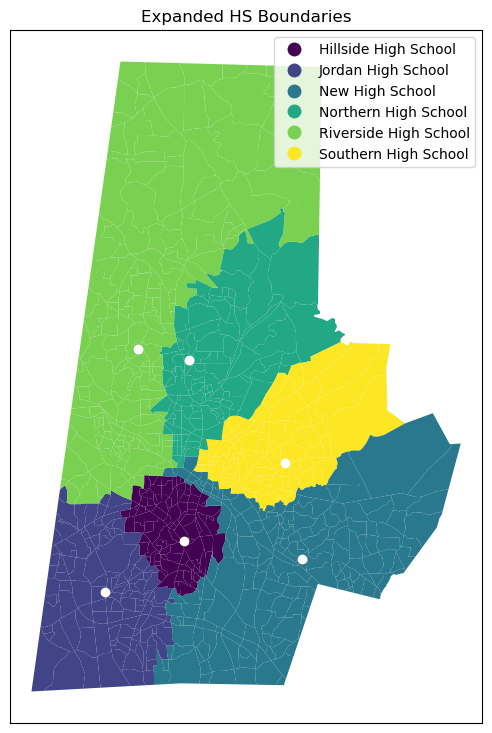

In [13]:
fig,ax = plt.subplots(figsize = (7,9))

hs_full_geo.plot(
    column='assign',
    ax = ax,
    cmap = 'viridis',
    legend = True
)

ax.set_xticks([])
ax.set_yticks([])

plt.title('Expanded HS Boundaries')
dps_base_hs.plot(ax=plt.gca(), color = 'white')

<Axes: title={'center': 'Expanded HS Boundaries'}>

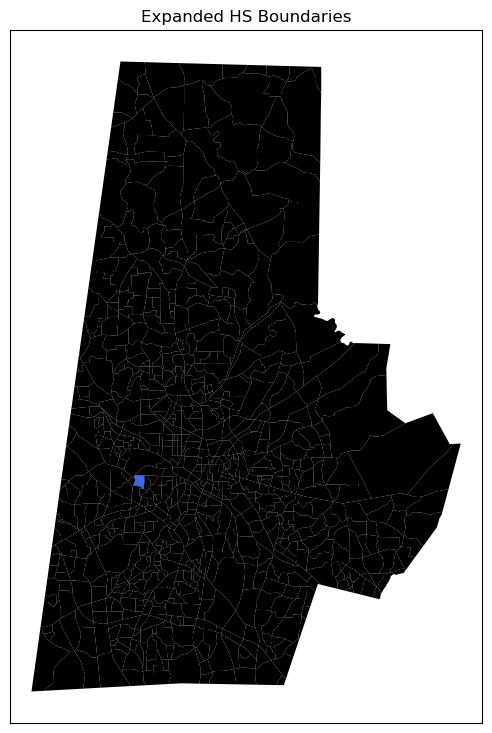

In [31]:
fig,ax = plt.subplots(figsize = (7,9))

hs_2028_geo.plot(
    ax = ax,
    color = 'black'
)

ax.set_xticks([])
ax.set_yticks([])

plt.title('Expanded HS Boundaries')
hs_2028_geo.loc[[12],'geometry'].plot(ax=plt.gca(), color = 'royalblue')


In [32]:
all_scores_30_1 = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\all_scores_FINAL.geojson')

Text(0.5, 1.0, 'Log(Objective Score) by Site Location')

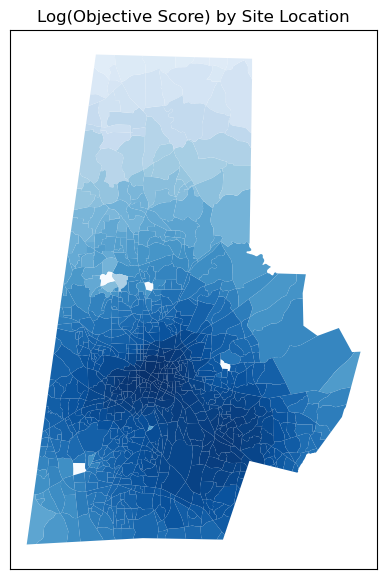

In [33]:
fig,ax = plt.subplots(figsize=(9,7))

all_scores_30_1.plot(
    column='log_score',
    ax=ax,
    cmap='Blues_r',
    legend=False
)

ax.set_xticks([])
ax.set_yticks([])

plt.title('Log(Objective Score) by Site Location')